In [1]:
from utils import get_core_set
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.rcParams['font.family'] = "Arial" # 设置字体族为你指定的字体
DPI = 600

In [2]:
def get_df_rmsd(model_list: list[str], result_dir: Path) -> pd.DataFrame:
    df_list = []
    for model_name in model_list:
        df_rmsd = pd.read_csv(result_dir / f"rmsd_{model_name}.csv")
        df_list.append(df_rmsd)
    return pd.concat(df_list)

In [8]:
model_list = ["af3", "chai", "helix", "afm", "rfaa"]
results_dir = Path("../results")

df_rmsd = get_df_rmsd(model_list, results_dir)
df_rmsd["model_name"] = df_rmsd["job_id"].apply(lambda x: x.split("_")[2])
df_rmsd["seed"] = df_rmsd["job_id"].apply(lambda x: x.split("_")[4])
df_summary = pd.read_csv("../summary_jobs.csv")

# 过滤掉长度大于 30 的多肽
print(len(df_summary))
df_summary = df_summary[df_summary["peptide_chain_len"] <= 30]
print(len(df_summary))

fullset_df = df_summary.copy()
coreset_df = get_core_set(df_summary)

df_rmsd_full = fullset_df.copy()
df_rmsd_core = df_rmsd[df_rmsd["job_name"].isin(coreset_df["job_name"])]

284
266
len(full_set): 266
Test Independant Set (N): 172
Test Redundent Set (N): 32
Train Redundent Set (N): 79



In [9]:
def plot_rmsd(df: pd.DataFrame, metric="rmsd", seed_mode=False):

    result_list = []
    for model_name, model_group in df.groupby("model_name"):
        for job_name, job_group in model_group.groupby("job_name"):
            result = {"model_name": model_name, "job_name": job_name}
            
            if seed_mode:
                score_seed_list = [
                    seed_group[metric].sort_values().iloc[0]
                    for _, seed_group in job_group.groupby("seed")
                ]
                result[metric] = np.mean(score_seed_list)
            else:
                result[metric] = job_group[metric].sort_values().iloc[0]
            
            result_list.append(result)
    
    result_df = pd.DataFrame(result_list)
    
    grouped = result_df.groupby("model_name")[metric]
    statistics = grouped.agg(["mean", "min", "max", "median"])
    
    for model in statistics.index:
        print(
            f"Model: {model}, "
            f"Mean {metric}: {statistics.loc[model, ('mean')]}, "
            f"Min {metric}: {statistics.loc[model, ('min')]}, "
            f"Max {metric}: {statistics.loc[model, ('max')]}, "
            f"Median {metric}: {statistics.loc[model, ('median')]}"
        )
    
    result_df["mean_value"] = result_df["model_name"].map(statistics["mean"])
    result_df = result_df.sort_values(by="mean_value", ascending=True)
    
    # 绘制箱型图
    fig, ax = plt.subplots(figsize=(8, 6), dpi=DPI)
    sns.boxplot(
        data=result_df,
        x="model_name",
        y=metric,
        hue="model_name",
        palette="Set3",
        showmeans=True,
        ax=ax
    )

    # 设置图表标签
    ax.set_xlabel("Model")
    ax.set_ylabel(f"{metric}")

    # 旋转x轴标签
    plt.xticks(rotation=45)

    # 显示图形
    plt.tight_layout()
    plt.show()

Model: af3, Mean peptide_aligned_rmsd: 6.173969629989246, Min peptide_aligned_rmsd: 0.2787728007121752, Max peptide_aligned_rmsd: 36.18640720580091, Median peptide_aligned_rmsd: 2.2572836746156204
Model: afm, Mean peptide_aligned_rmsd: 7.036728216142239, Min peptide_aligned_rmsd: 0.4663077282779171, Max peptide_aligned_rmsd: 46.79829370112927, Median peptide_aligned_rmsd: 3.124942522986797
Model: chai, Mean peptide_aligned_rmsd: 6.6652204456372015, Min peptide_aligned_rmsd: 0.3869209724308235, Max peptide_aligned_rmsd: 38.77286175425737, Median peptide_aligned_rmsd: 3.5599527102797572
Model: helix, Mean peptide_aligned_rmsd: 8.09359407962998, Min peptide_aligned_rmsd: 0.4479042868693346, Max peptide_aligned_rmsd: 60.78575642972525, Median peptide_aligned_rmsd: 3.8136489611557165
Model: rfaa, Mean peptide_aligned_rmsd: 9.500123643001881, Min peptide_aligned_rmsd: 0.7383766058324759, Max peptide_aligned_rmsd: 50.2963714770066, Median peptide_aligned_rmsd: 6.32760518240277


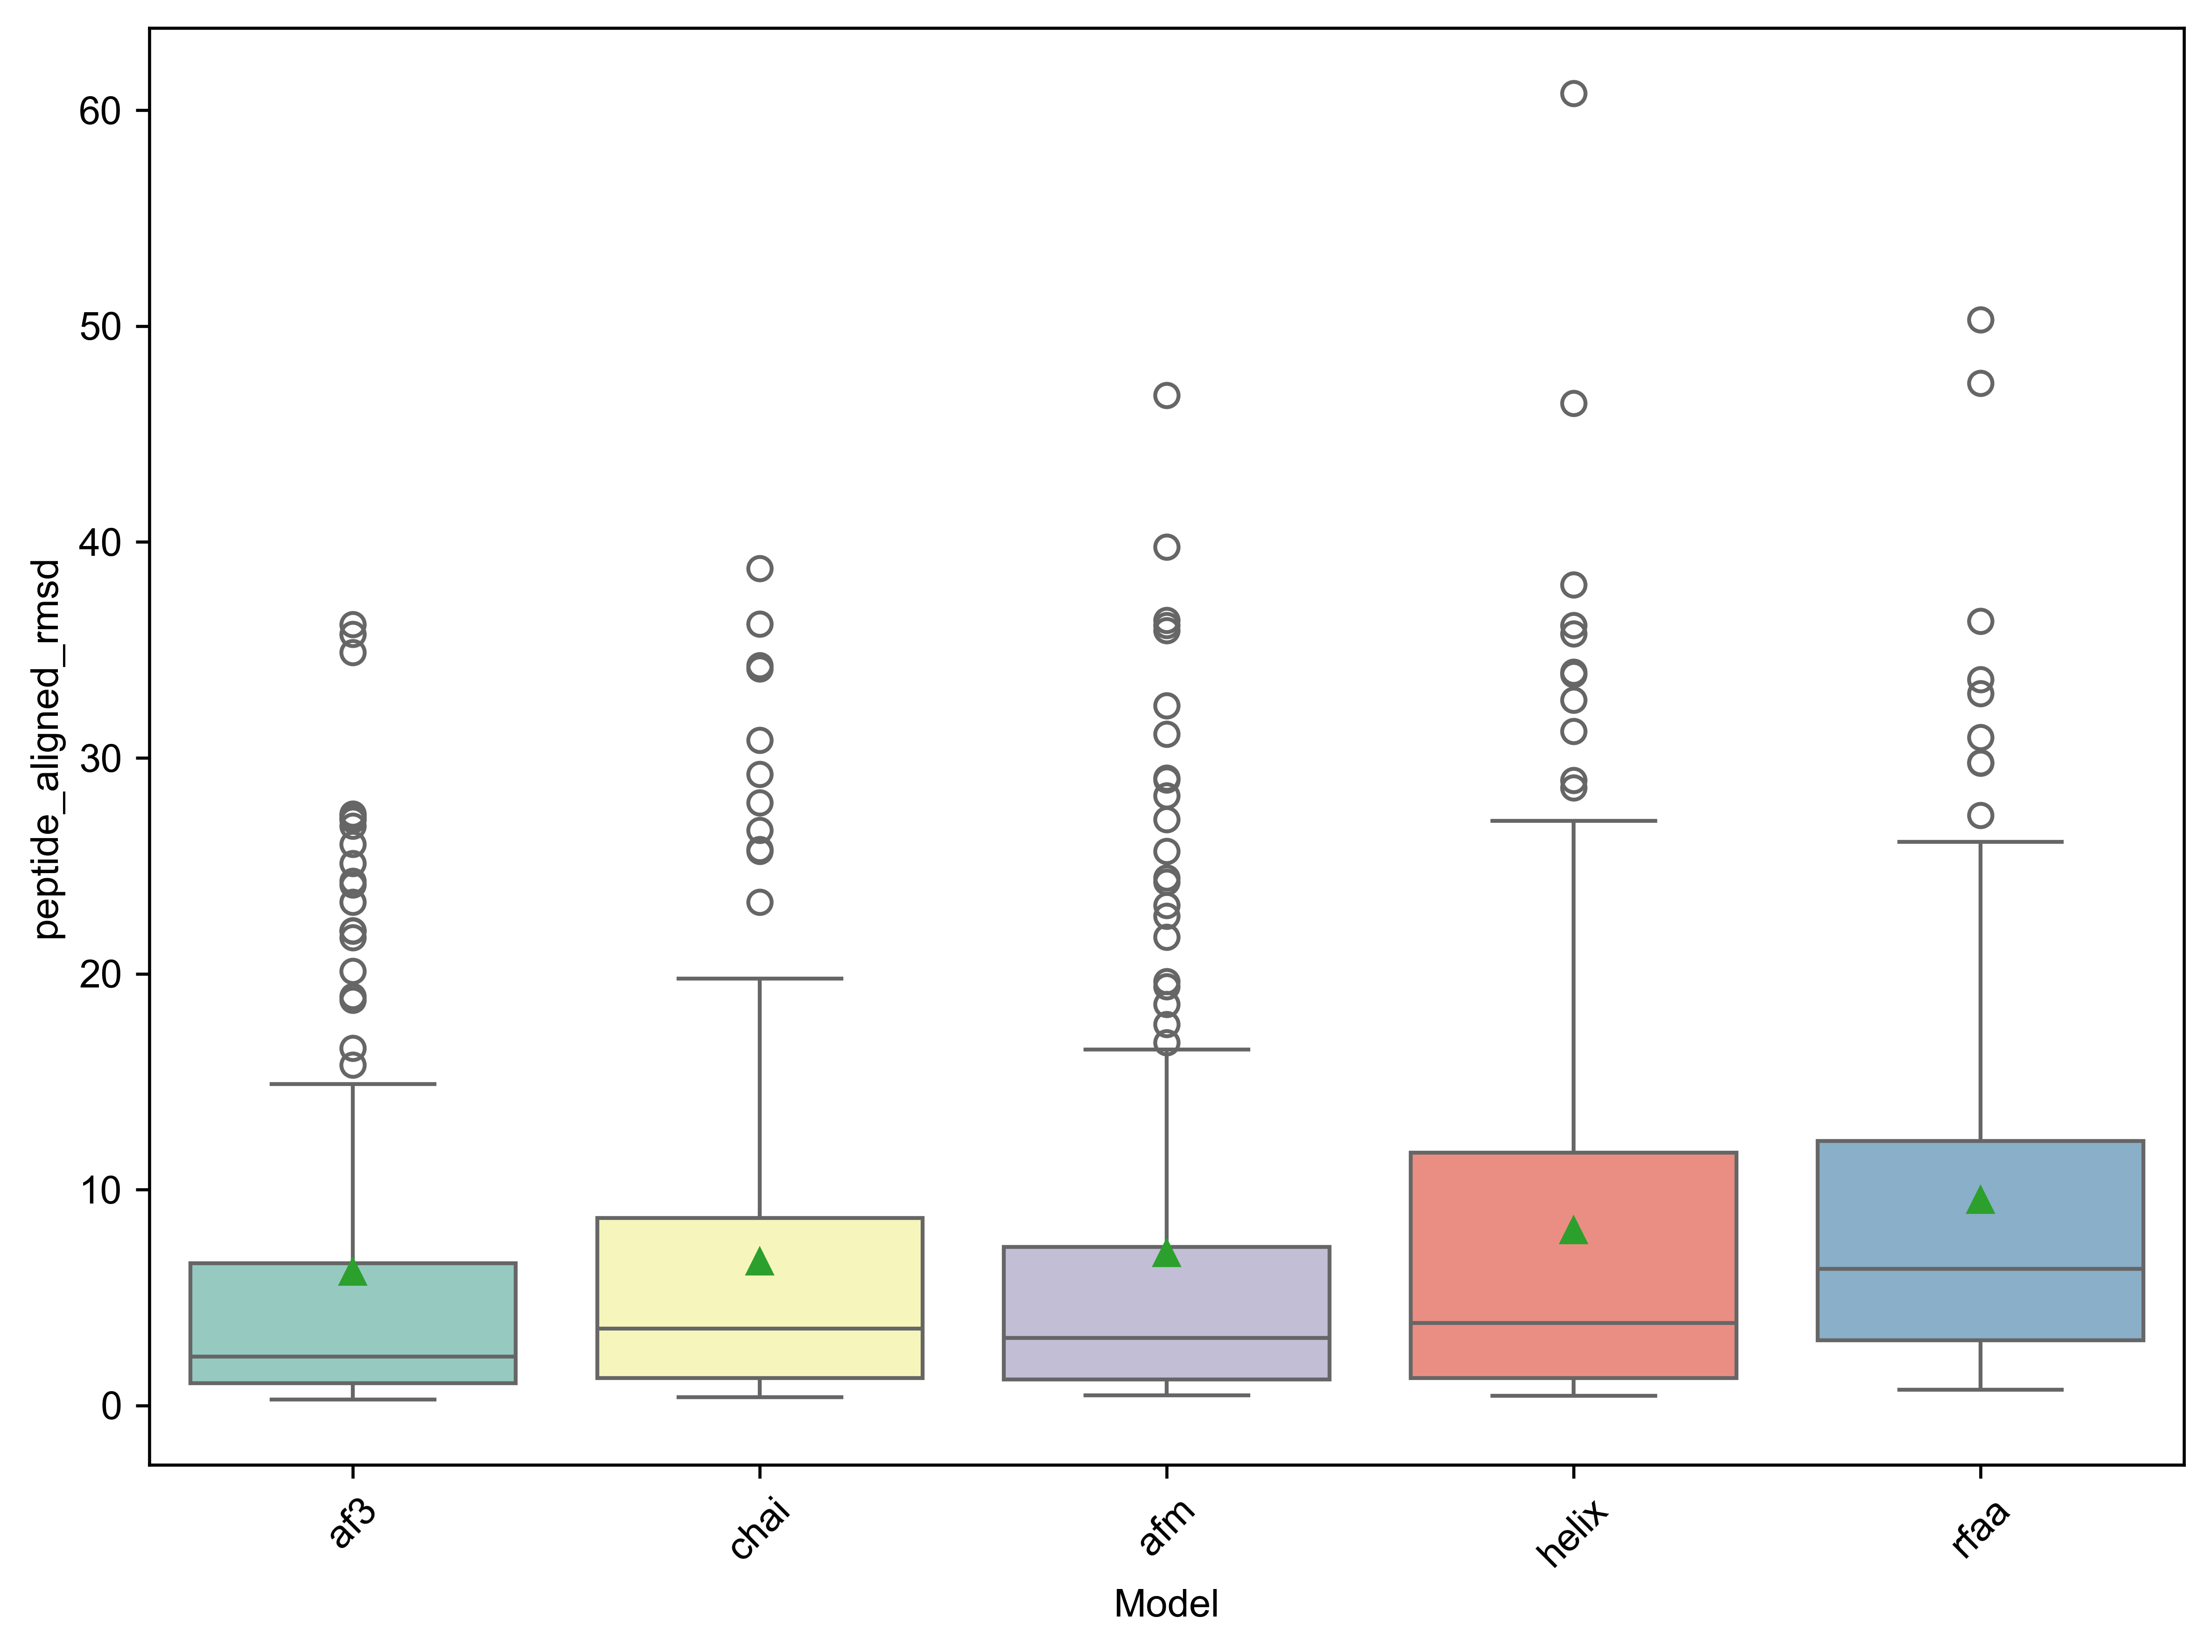

In [10]:
plot_rmsd(df_rmsd_core, "peptide_aligned_rmsd")

Model: af3, Mean peptide_aligned_rmsd: 6.173969629989246, Min peptide_aligned_rmsd: 0.2787728007121752, Max peptide_aligned_rmsd: 36.18640720580091, Median peptide_aligned_rmsd: 2.2572836746156204
Model: afm, Mean peptide_aligned_rmsd: 7.036728216142239, Min peptide_aligned_rmsd: 0.4663077282779171, Max peptide_aligned_rmsd: 46.79829370112927, Median peptide_aligned_rmsd: 3.124942522986797
Model: chai, Mean peptide_aligned_rmsd: 6.6652204456372015, Min peptide_aligned_rmsd: 0.3869209724308235, Max peptide_aligned_rmsd: 38.77286175425737, Median peptide_aligned_rmsd: 3.5599527102797572
Model: helix, Mean peptide_aligned_rmsd: 8.09359407962998, Min peptide_aligned_rmsd: 0.4479042868693346, Max peptide_aligned_rmsd: 60.78575642972525, Median peptide_aligned_rmsd: 3.8136489611557165
Model: rfaa, Mean peptide_aligned_rmsd: 9.500123643001881, Min peptide_aligned_rmsd: 0.7383766058324759, Max peptide_aligned_rmsd: 50.2963714770066, Median peptide_aligned_rmsd: 6.32760518240277


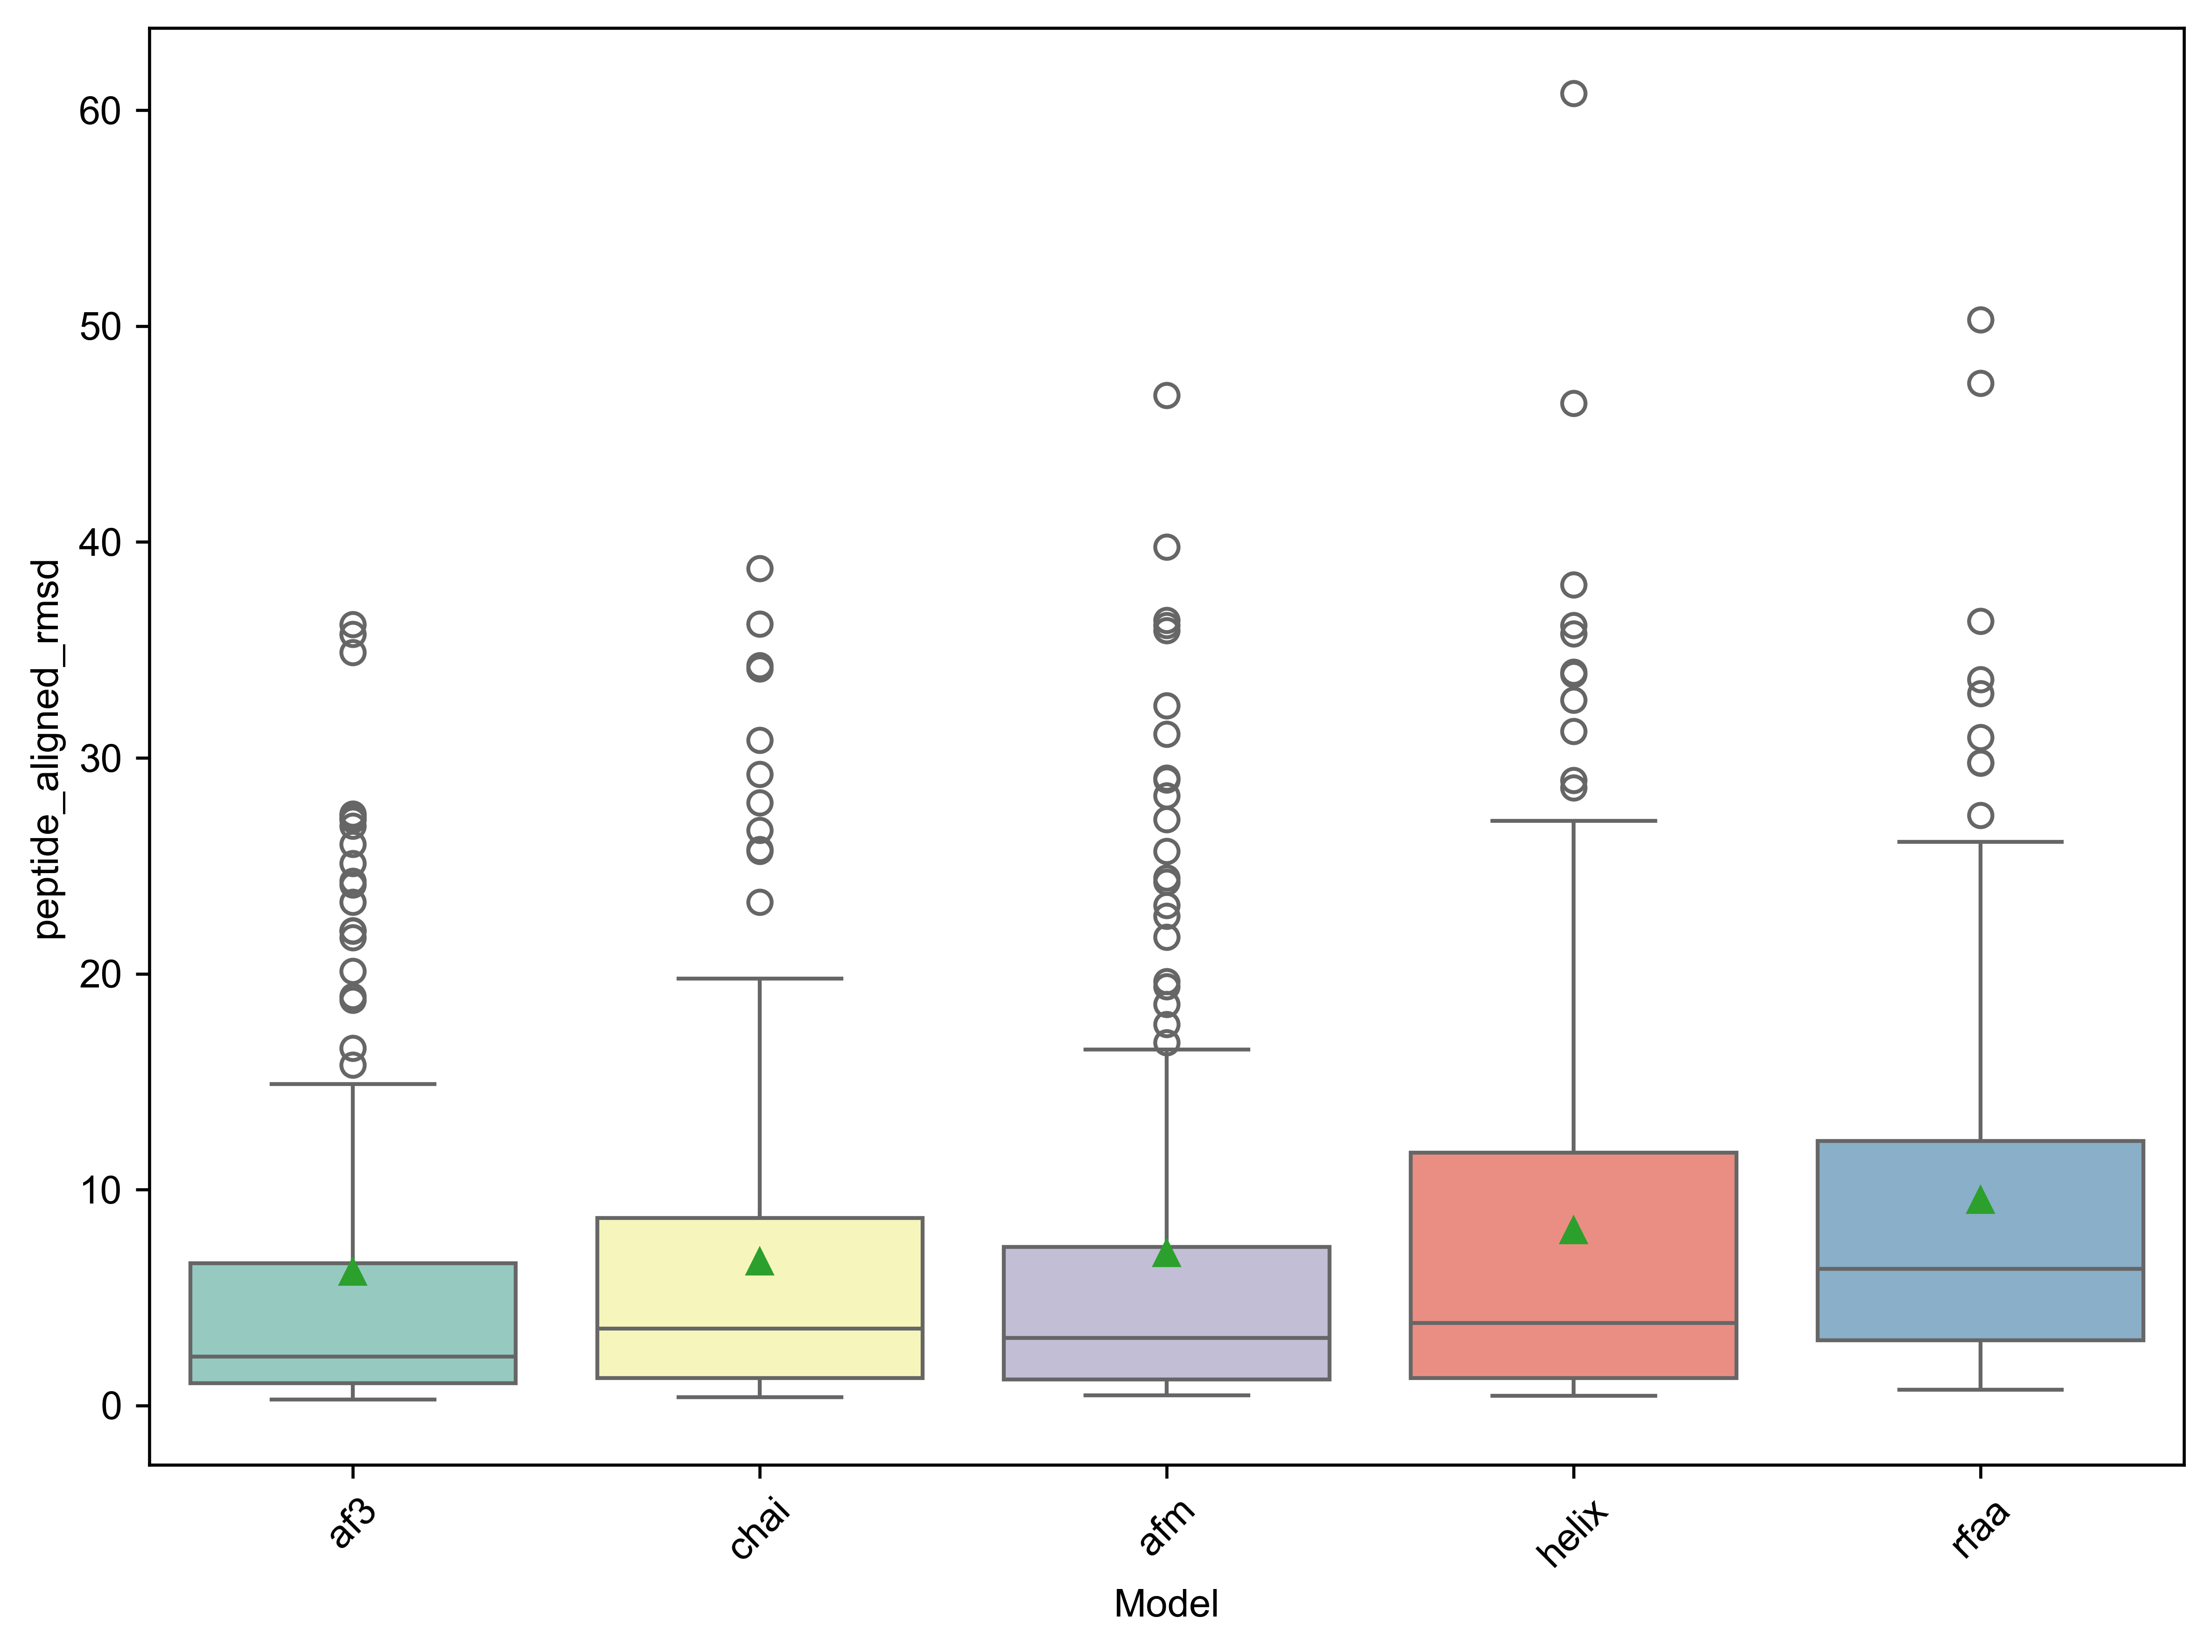

In [ ]:
# peptide_aligned_rmsd,peptide_rmsd,protein_rmsd
plot_rmsd(df_rmsd_core, "peptide_aligned_rmsd")

Model: af3, Mean peptide_rmsd: 1.2518774528749332, Min peptide_rmsd: 0.1504558695273439, Max peptide_rmsd: 5.32216661797936, Median peptide_rmsd: 0.9410058524811442
Model: afm, Mean peptide_rmsd: 1.4595019591398999, Min peptide_rmsd: 0.203913065918995, Max peptide_rmsd: 6.402411445239402, Median peptide_rmsd: 1.192675414869378
Model: chai, Mean peptide_rmsd: 1.6411826671773484, Min peptide_rmsd: 0.1983341848955799, Max peptide_rmsd: 7.5628023925761, Median peptide_rmsd: 1.303380316877776
Model: helix, Mean peptide_rmsd: 1.5377103738325408, Min peptide_rmsd: 0.2009479648295297, Max peptide_rmsd: 6.184376291526929, Median peptide_rmsd: 1.137882316872191
Model: rfaa, Mean peptide_rmsd: 1.639083362617411, Min peptide_rmsd: 0.0, Max peptide_rmsd: 5.199890163501924, Median peptide_rmsd: 1.4119395424106966


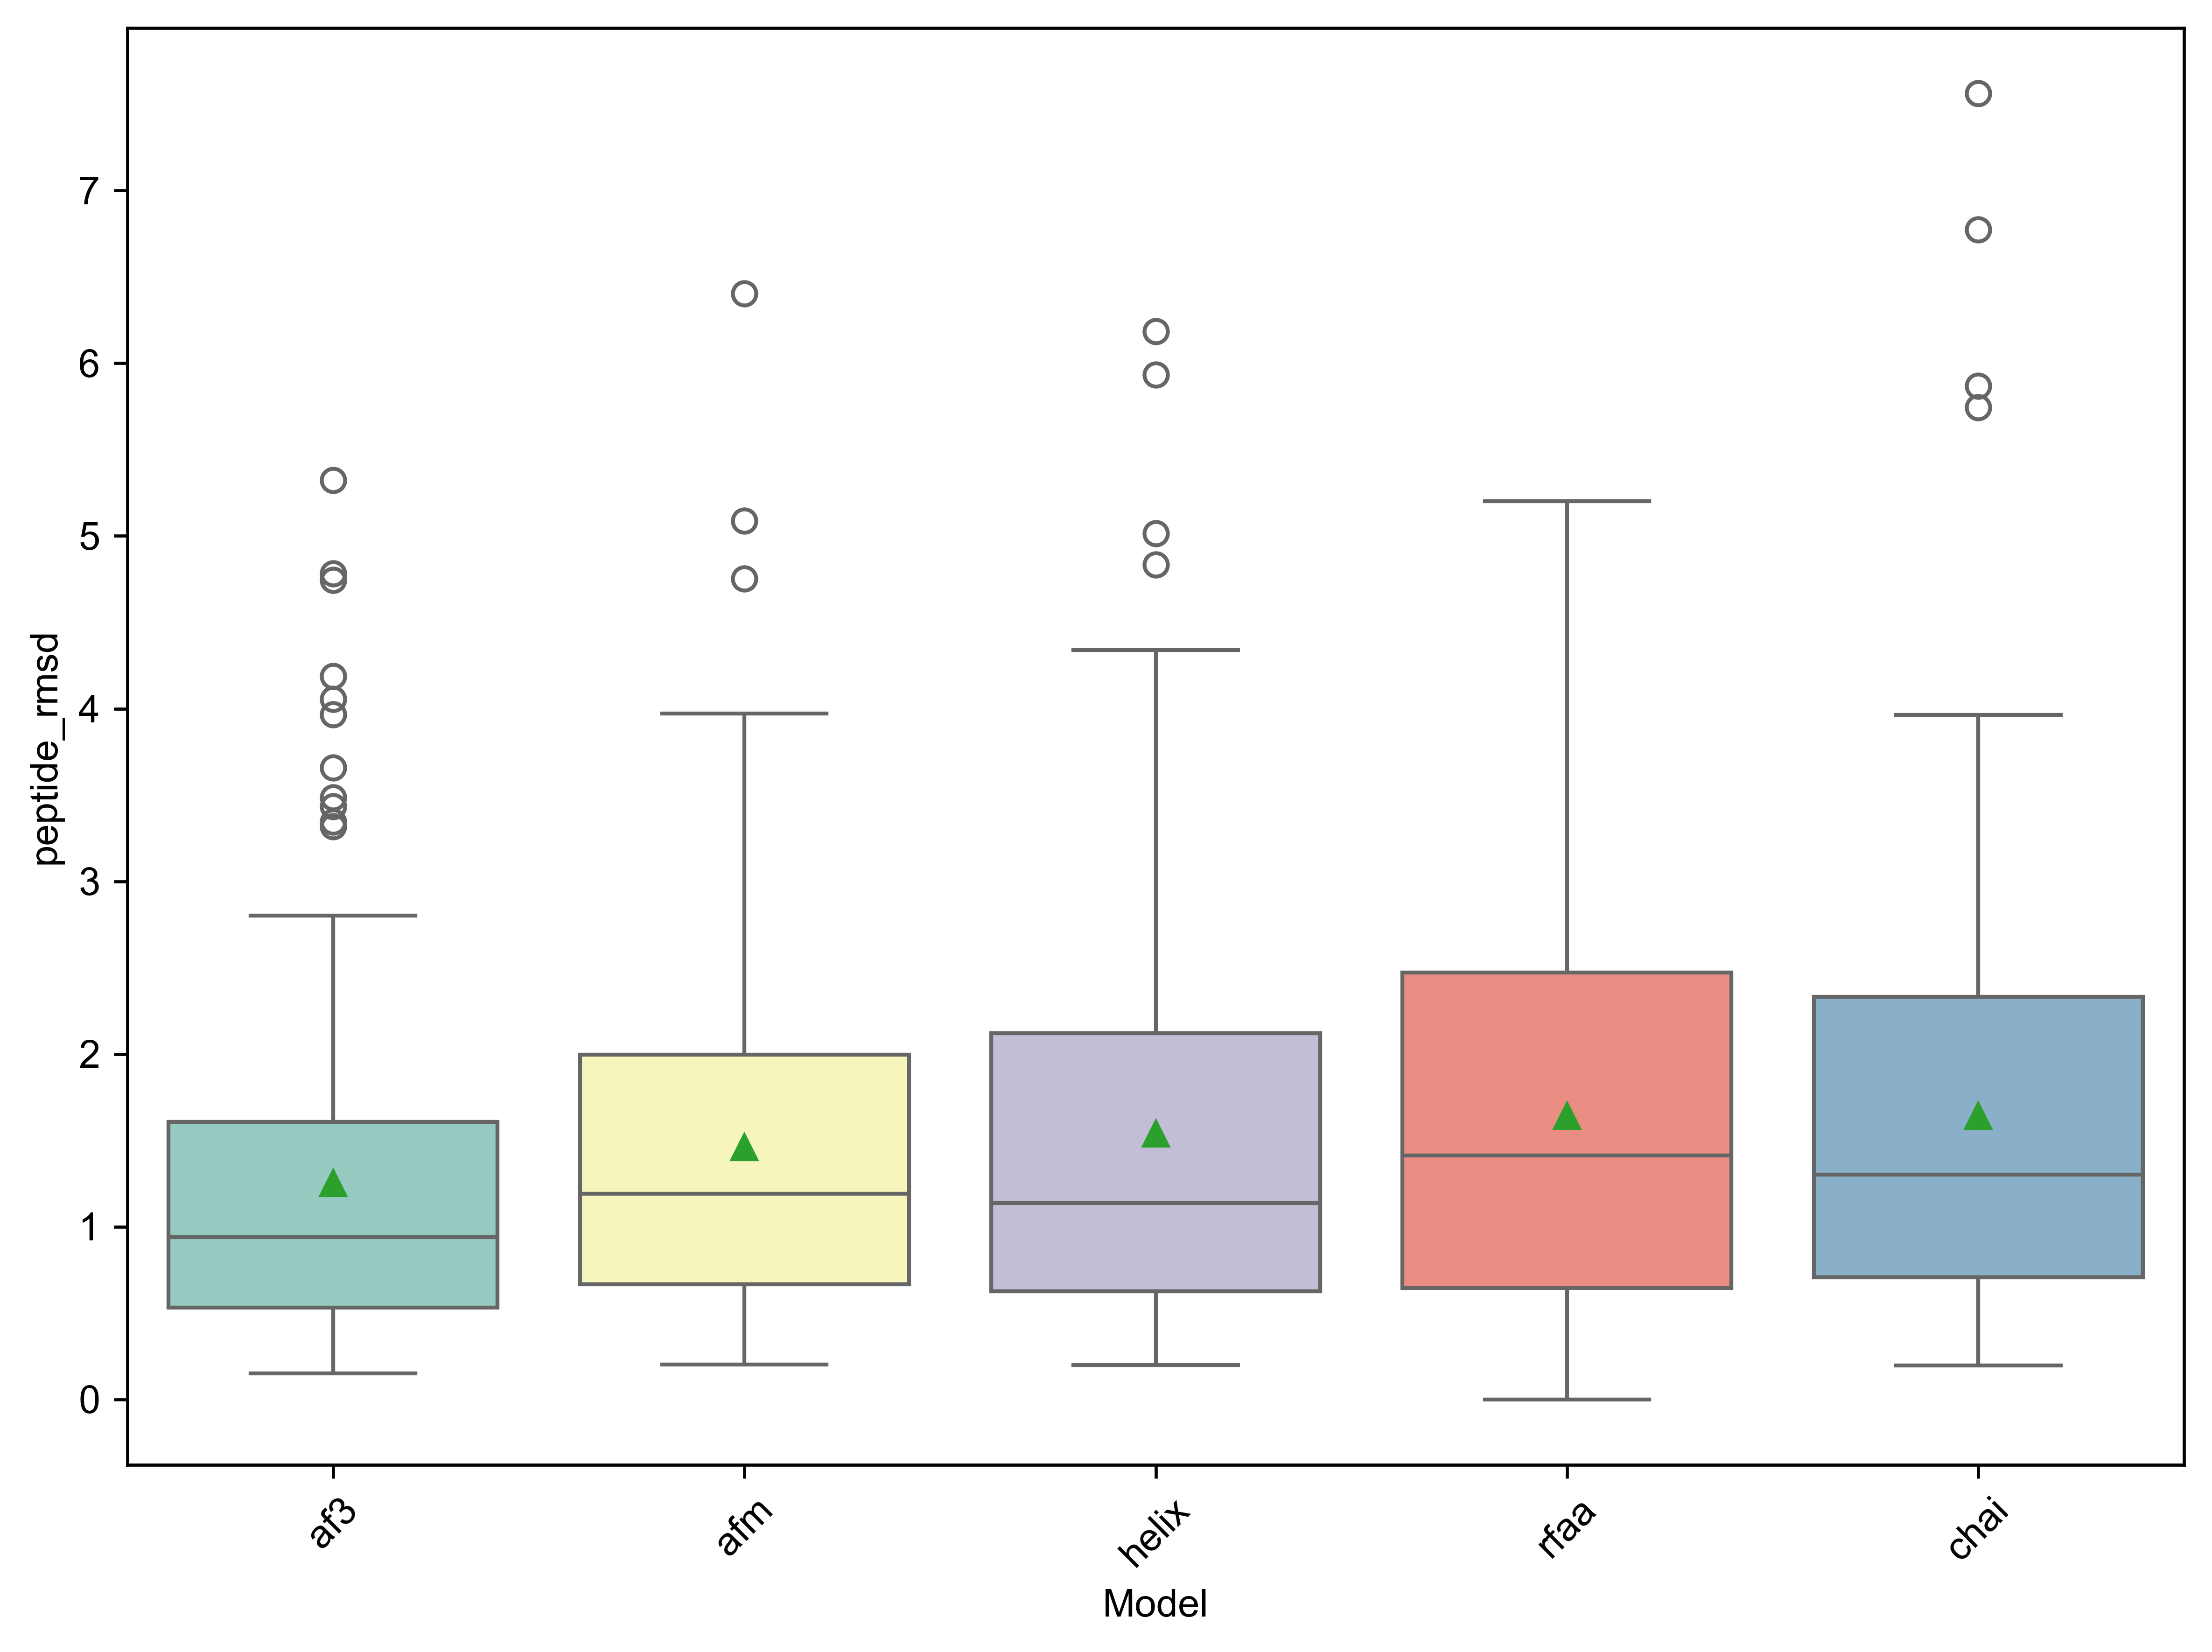

In [6]:
plot_rmsd(df_rmsd_core, "peptide_rmsd")

Model: af3, Mean protein_rmsd: 2.9838777506835696, Min protein_rmsd: 0.1871618145011615, Max protein_rmsd: 31.43767698048139, Median protein_rmsd: 0.9043834898368597
Model: afm, Mean protein_rmsd: 3.167090322325003, Min protein_rmsd: 0.2552791947586225, Max protein_rmsd: 31.44701092306982, Median protein_rmsd: 0.9580145928865822
Model: chai, Mean protein_rmsd: 3.07132414495539, Min protein_rmsd: 0.2382967794959909, Max protein_rmsd: 35.5822497417641, Median protein_rmsd: 0.9410272352929487
Model: helix, Mean protein_rmsd: 3.68033927995749, Min protein_rmsd: 0.2943562105882905, Max protein_rmsd: 35.89248213680999, Median protein_rmsd: 1.01040378747023
Model: rfaa, Mean protein_rmsd: 5.12213940388046, Min protein_rmsd: 0.4466938256520333, Max protein_rmsd: 30.11941948152356, Median protein_rmsd: 1.4071073059423256


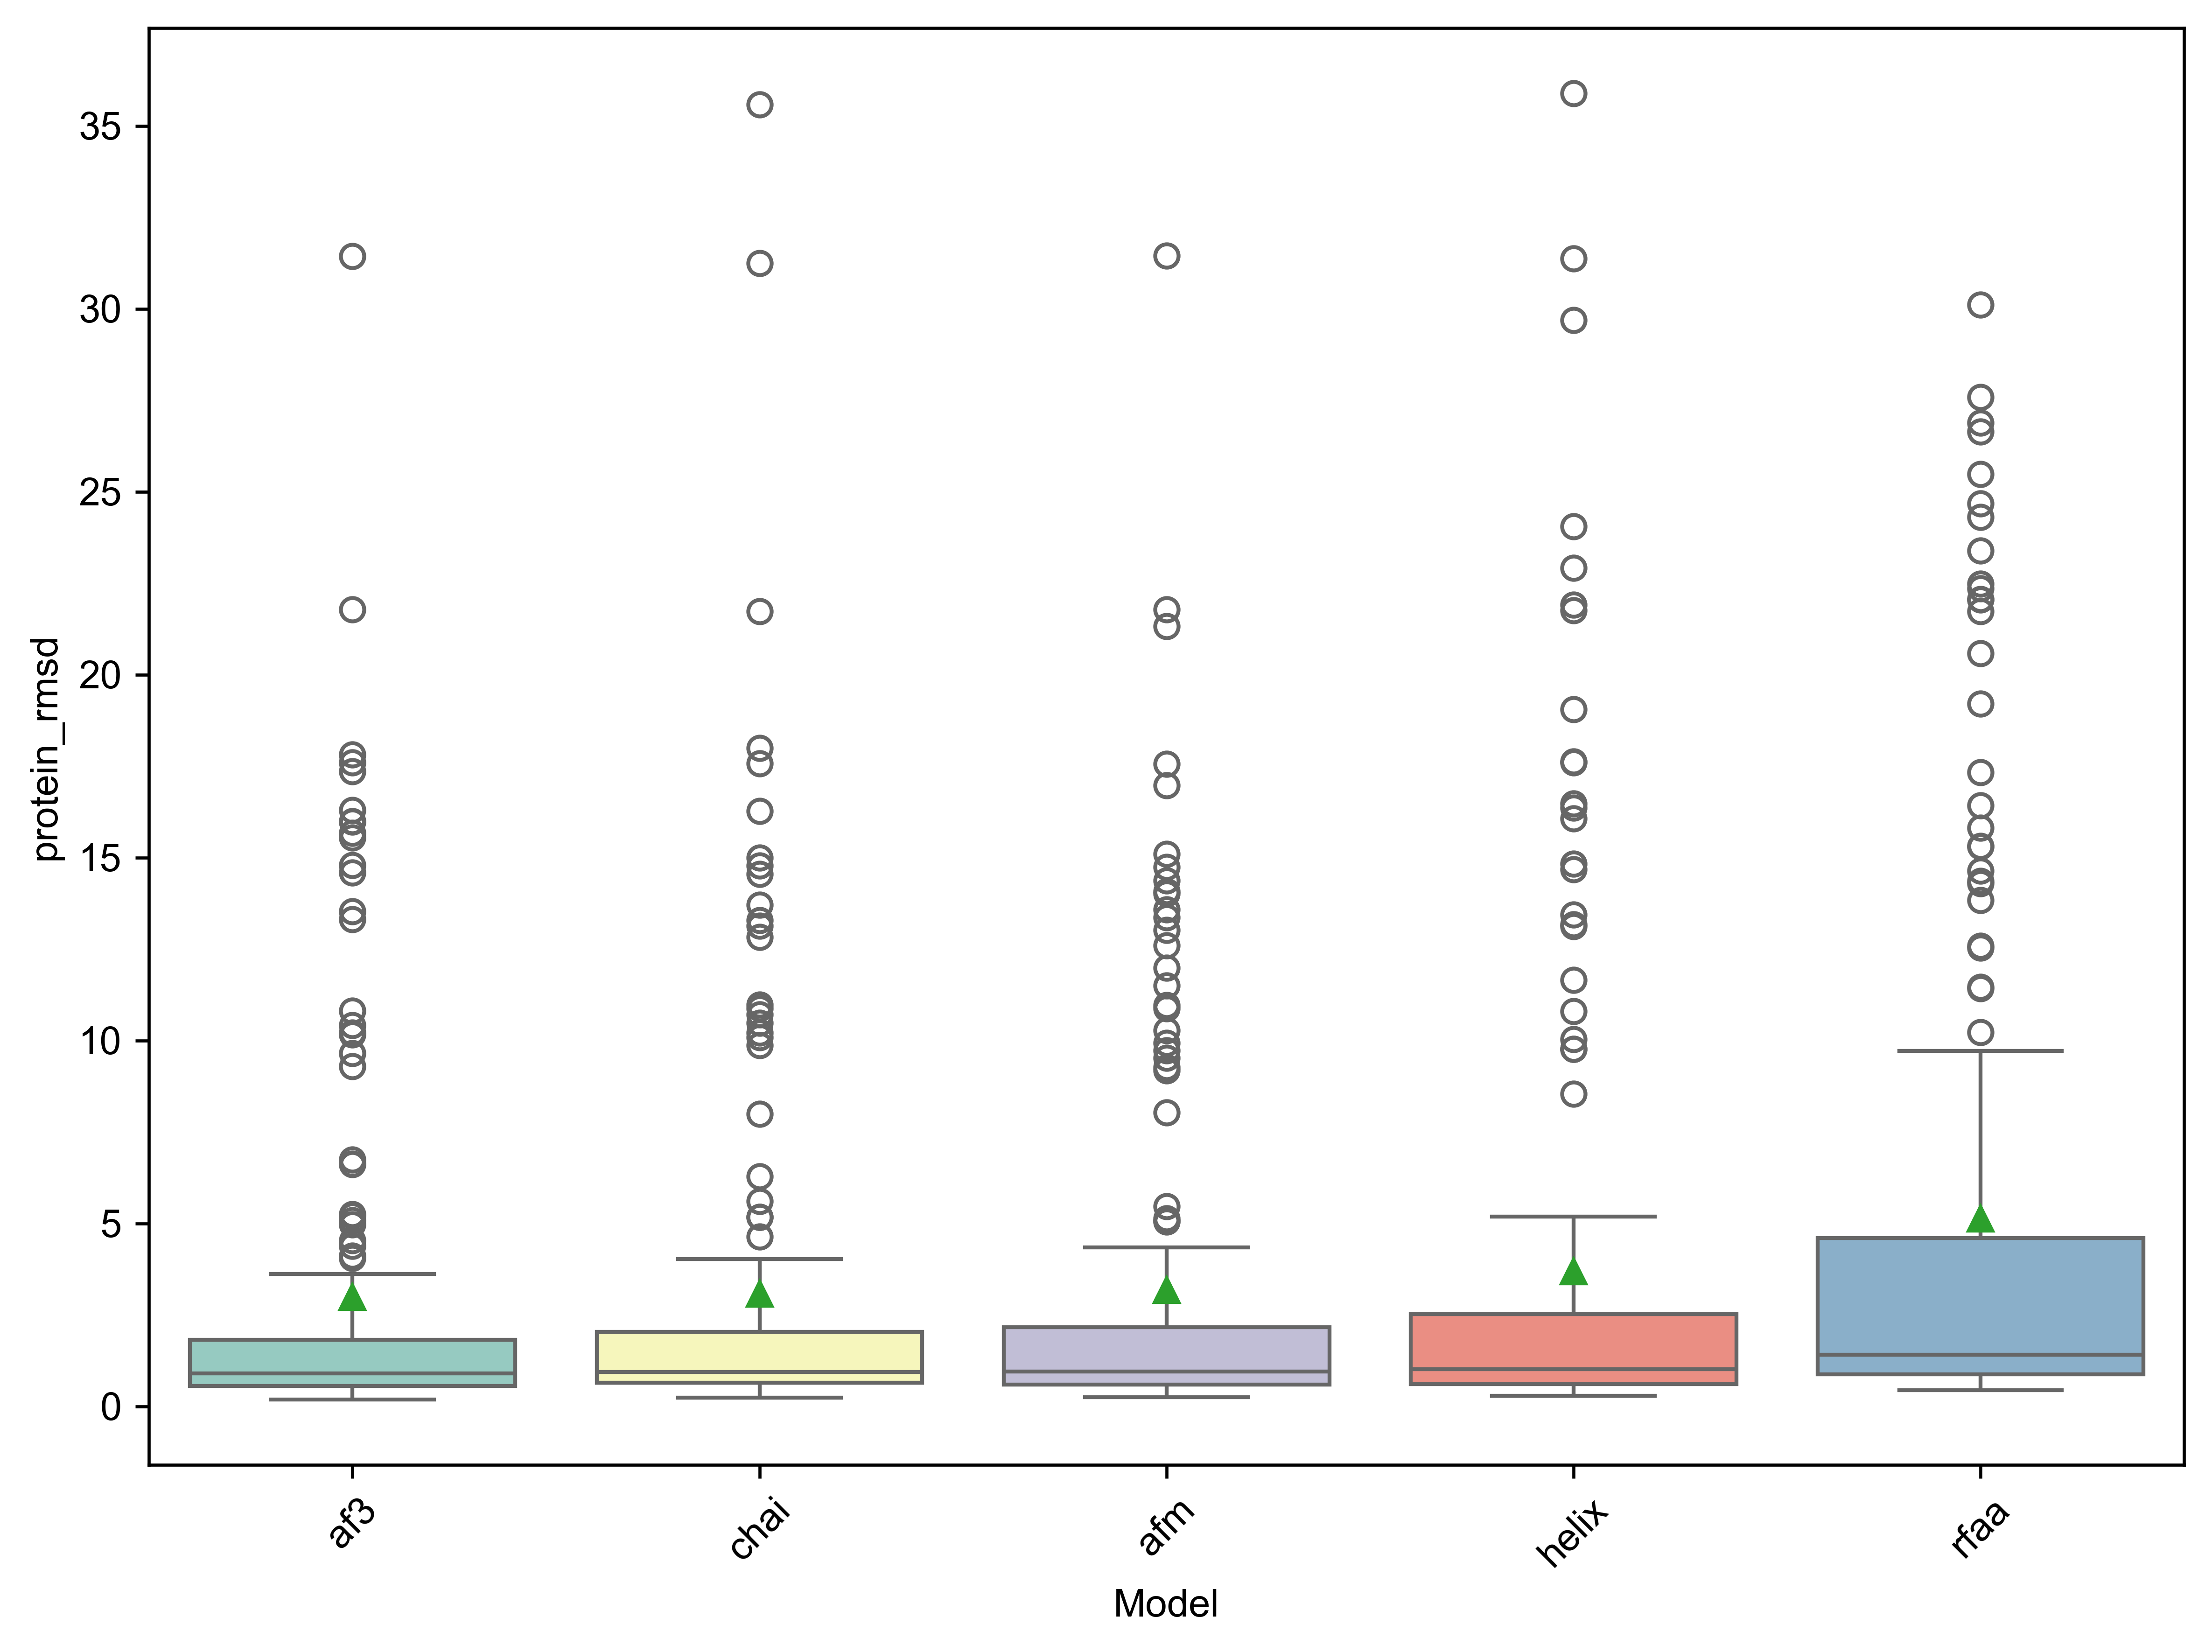

In [7]:
plot_rmsd(df_rmsd_core, "protein_rmsd")